## Dataset information as per Kaggle (https://www.kaggle.com/competitions/icr-identify-age-related-conditions/data)

1. **train.csv** - The training set.
   * `Id` Unique identifier for each observation.
   * `AB-GL` Fifty-six anonymized health characteristics. All are numeric except for EJ, which is categorical.
   * `Class` A binary target: 1 indicates the subject has been diagnosed with one of the three conditions, 0 indicates they have not.
2. **test.csv** - The test set. Your goal is to predict the probability that a subject in this set belongs to each of the two classes.
3. **greeks.csv** - Supplemental metadata, only available for the training set.
   * `Alpha` Identifies the type of age-related condition, if present.
     * `A` No age-related condition. Corresponds to class 0.
     * `B`, `D`, `G` The three age-related conditions. Correspond to class 1.
   * `Beta`, `Gamma`, `Delta` Three experimental characteristics.
   * `Epsilon` The date the data for this subject was collected. Note that all of the data in the test set was collected after the training set was collected.

# To-do for preprocessing

1. Class weights
2. Finalize hyperparameters
   1. n_neighbors
   2. num_features
   3. ~~Test % split~~ 80-20

OH Questions:
1. kPCA vs PCA: kPCA over PCA if the data is nonlinear, but what’s the best way to determine linearity?
   1. Answer: rbf kernel to start with kPCA. Since we don’t know anything about the data, we should test model performance between kPCA and PCA as the data may or may not be linear
2. tSNE
   1. Answer: split afterwards does not matter. It works completely differently from PCA so tSNE doing the split afterwards is okay.
      1. I asked about issues with EDA graphs not having the same data split and she didn’t seem to thing it would be a big issue
3. Variance
   1. Answer: pca.explained_variance_ratio_. See week08 `dimensionality_reduction.ipynb`. Search for `pca.explained_variance_ratio_`
   2. The variance for tSNE *should* have something similar as above

In [20]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf, keras, and sklearn
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

from mlxtend.plotting import heatmap

# Stats library
import statsmodels.api as sm

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

In [26]:
greeks = pd.read_csv('../data/greeks.csv')
test = pd.read_csv('../data/test.csv')
train = pd.read_csv('../data/train.csv')

greeks.columns = map(str.lower, greeks.columns)
test.columns = map(str.lower, test.columns)
train.columns = map(str.lower, train.columns)

print('Shape of greeks df:', greeks.shape)
print('Shape of test df:', test.shape)
print('Shape of train df:', train.shape)

# Merge train and greeks to get all columns in the same DataFrame
df = pd.merge(train, greeks, on='id')

Shape of greeks df: (617, 6)
Shape of test df: (5, 57)
Shape of train df: (617, 58)


In [27]:
# One-hot encode EJ so it could be used in tSNE or PCA
train = train.join(pd.get_dummies(train['ej'], dtype=int))
train.drop(['ej'], axis=1, inplace=True)

# Binary target variable
target_variable = train['class']
features_variable = train.drop(['class', 'id'], axis=1)

# Fill in NaN values via KNNImputer
imputer = KNNImputer(n_neighbors=2)
features_variable = pd.DataFrame(imputer.fit_transform(features_variable))

features_variable.columns = train.drop(['class', 'id'], axis=1).columns

In [5]:
def feature_reduction(method, num_features, data_split, kernel = 'rbf'):
    
    if method == 'pca' or method == 'kpca':
        # Split into Train and Test
        X_train, X_test, y_train, y_test = train_test_split(features_variable, target_variable, test_size = data_split,
                                                            stratify=target_variable, random_state=0)
        # Standardize values via StandardScaler
        sc = StandardScaler().fit(X_train)

        X_train_std = sc.transform(X_train)
        X_test_std = sc.transform(X_test)

        # PCA/kPCA
        if method == 'pca':
            pca = PCA(n_components = num_features)
            pca.fit(X_train_std)
            variance_ratio = np.cumsum(pca.explained_variance_ratio_) * 100
            X_train_pca = pd.DataFrame(pca.transform(X_train_std))
            X_test_pca = pd.DataFrame(pca.transform(X_test_std))
        elif method == 'kpca':
            pca = KernelPCA(n_components = num_features, kernel = kernel)
            pca.fit(X_train_std)

            X_train_pca = pd.DataFrame(pca.transform(X_train_std))
            X_test_pca = pd.DataFrame(pca.transform(X_test_std))

            # kPCA does not have a feature for explained_variance_ratio_
            # because of the kernel transformation. The once the transformation
            # occurs, the data lives in a different feature space.
            # https://stackoverflow.com/a/40687862

            variance_ratio = None

        return X_train_pca, X_test_pca, y_train, y_test, variance_ratio

    elif method == 'tsne':
        # Standardize values via StandardScaler
        sc = StandardScaler().fit(features_variable)
        features_variable_std = sc.transform(features_variable)

        tsne = TSNE(n_components=num_features, random_state=0, perplexity=50, n_iter=5000, method = 'exact')

        # Calculate the 12 features via tSNE model
        features_variable_tsne = pd.DataFrame(tsne.fit_transform(features_variable_std))

        # kl_divergence (lower is better)
        divergence = tsne.kl_divergence_

        #Split into Train and Test
        X_train, X_test, y_train, y_test = train_test_split(features_variable_tsne, target_variable, test_size = data_split,
                                                            stratify=target_variable, random_state=0)
        return X_train, X_test, y_train, y_test, divergence


In [33]:
###################################
### Needs to be changed to what ###
### we finally decide upon      ###
### after testing hyperparams.  ###
###################################

X_train, X_test, Y_train, Y_test, statistic = feature_reduction(method='pca', num_features=24, data_split=0.2)

In [7]:
display(X_train.head())

# Display old features shape
display(features_variable.shape)

# Display new tSNE features shape
display(X_train.shape)

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
142,0.694633,3.350708,-3.527681,-1.103527,-1.477908,-0.931049,0.035388,-0.373270,-0.134268,0.912928,...,-0.305400,0.052309,0.112792,0.139960,0.240184,-0.079548,0.059624,1.602148,-0.038877,-0.053681
479,-2.037907,1.655050,-2.052831,-0.413652,-4.086355,-0.197123,0.057350,0.988930,-0.102798,1.241928,...,-2.027408,0.009217,-0.034384,0.073439,-0.101473,0.061123,-0.124020,0.629637,0.217968,0.001150
24,-0.391635,-2.644879,1.664351,1.145088,5.819466,0.972758,-2.009543,0.236569,0.084236,-1.479754,...,0.171516,-0.015731,-0.088107,-0.072623,-0.176401,0.080269,-0.254988,-0.061209,0.025007,0.436728
467,0.257988,0.937441,-4.186100,-0.608399,-0.465150,0.356029,0.016566,0.212401,-0.067344,0.158018,...,0.516725,0.004622,-0.054114,-0.654796,0.120291,-0.015073,-0.220144,0.081026,-0.247479,-0.026104
402,0.126603,-0.742463,1.726014,0.156986,0.241665,0.032716,0.004635,-0.095086,0.111316,-0.603553,...,0.188081,0.007880,-0.043637,-0.685753,-0.085767,0.032296,-0.064142,-0.268364,0.133199,0.051471


(617, 57)

(493, 56)

# EDA Visualizations

Below are visualizations of the following:

1. Heatmap before feature reduction
2. Distribution of features before reduction
3. Distribution of features after reduction
4. tSNE cluster visualization
5. PCA variance graph

### Heatmap before feature reduction

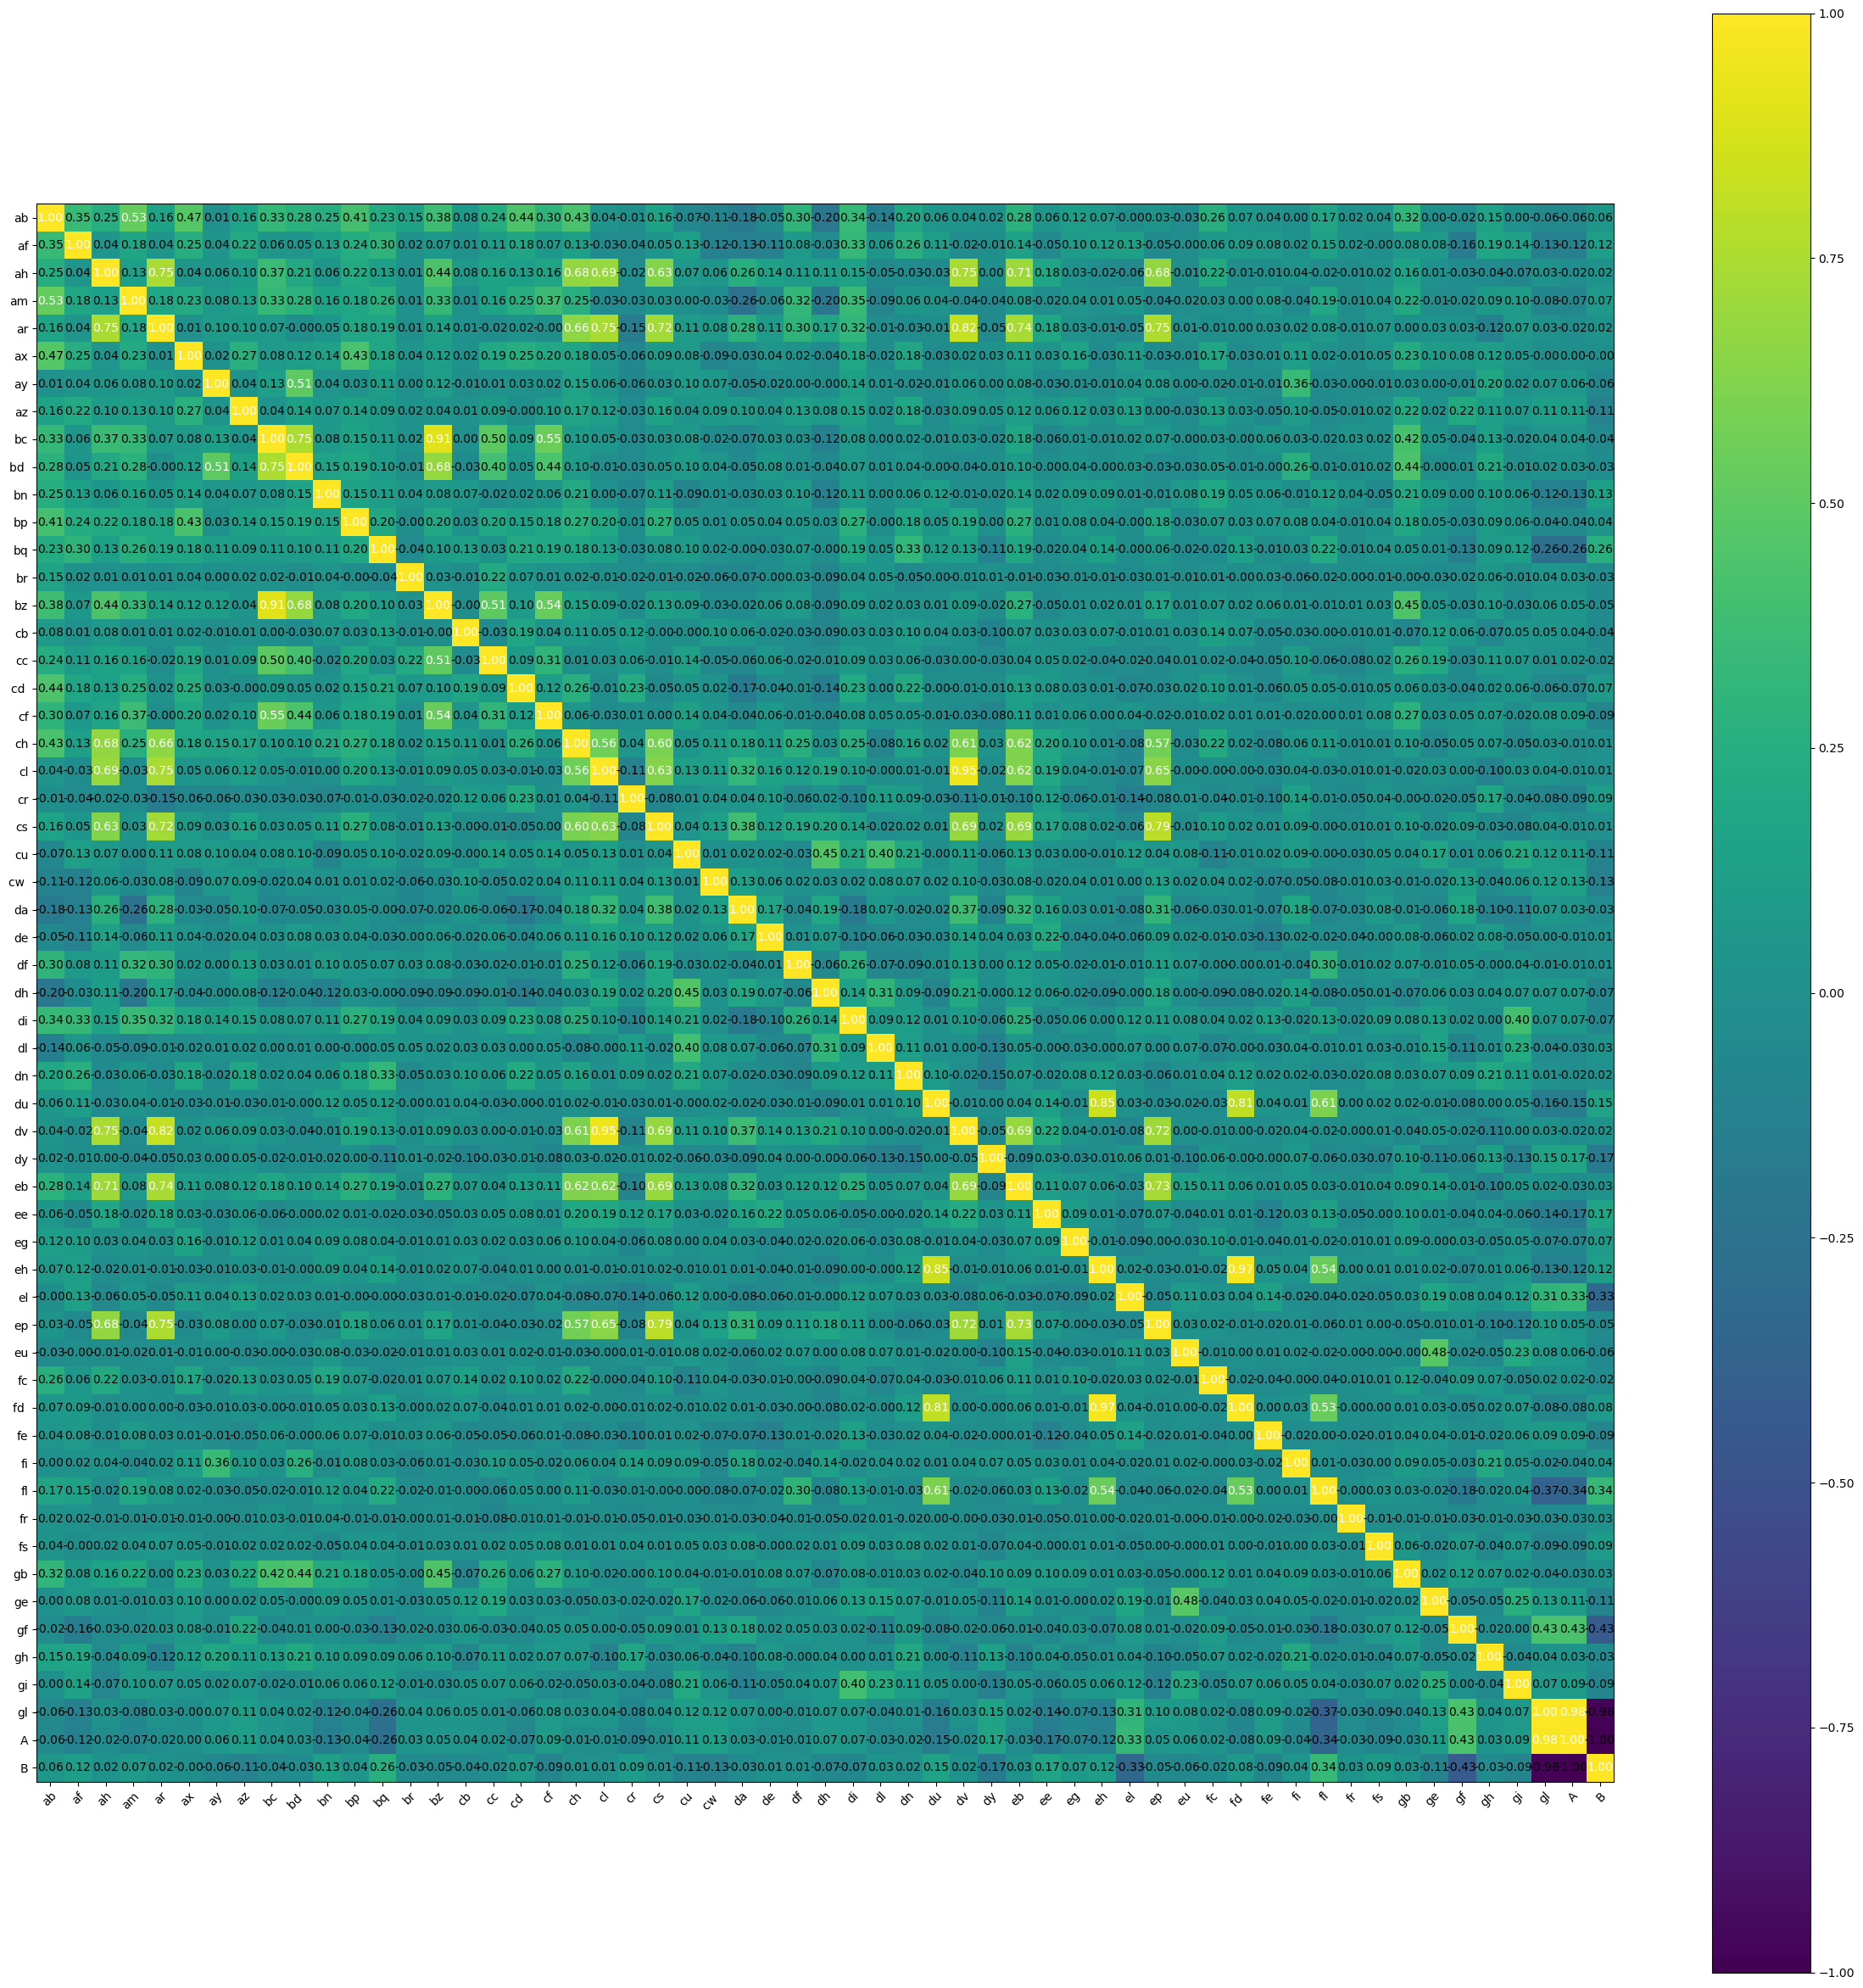

In [59]:
cm = features_variable.corr(numeric_only=False).values
hm = heatmap(
    cm,
    row_names=features_variable.columns,
    column_names=features_variable.columns,
    figsize=(30, 30)
)

### Distribution of features before reduction

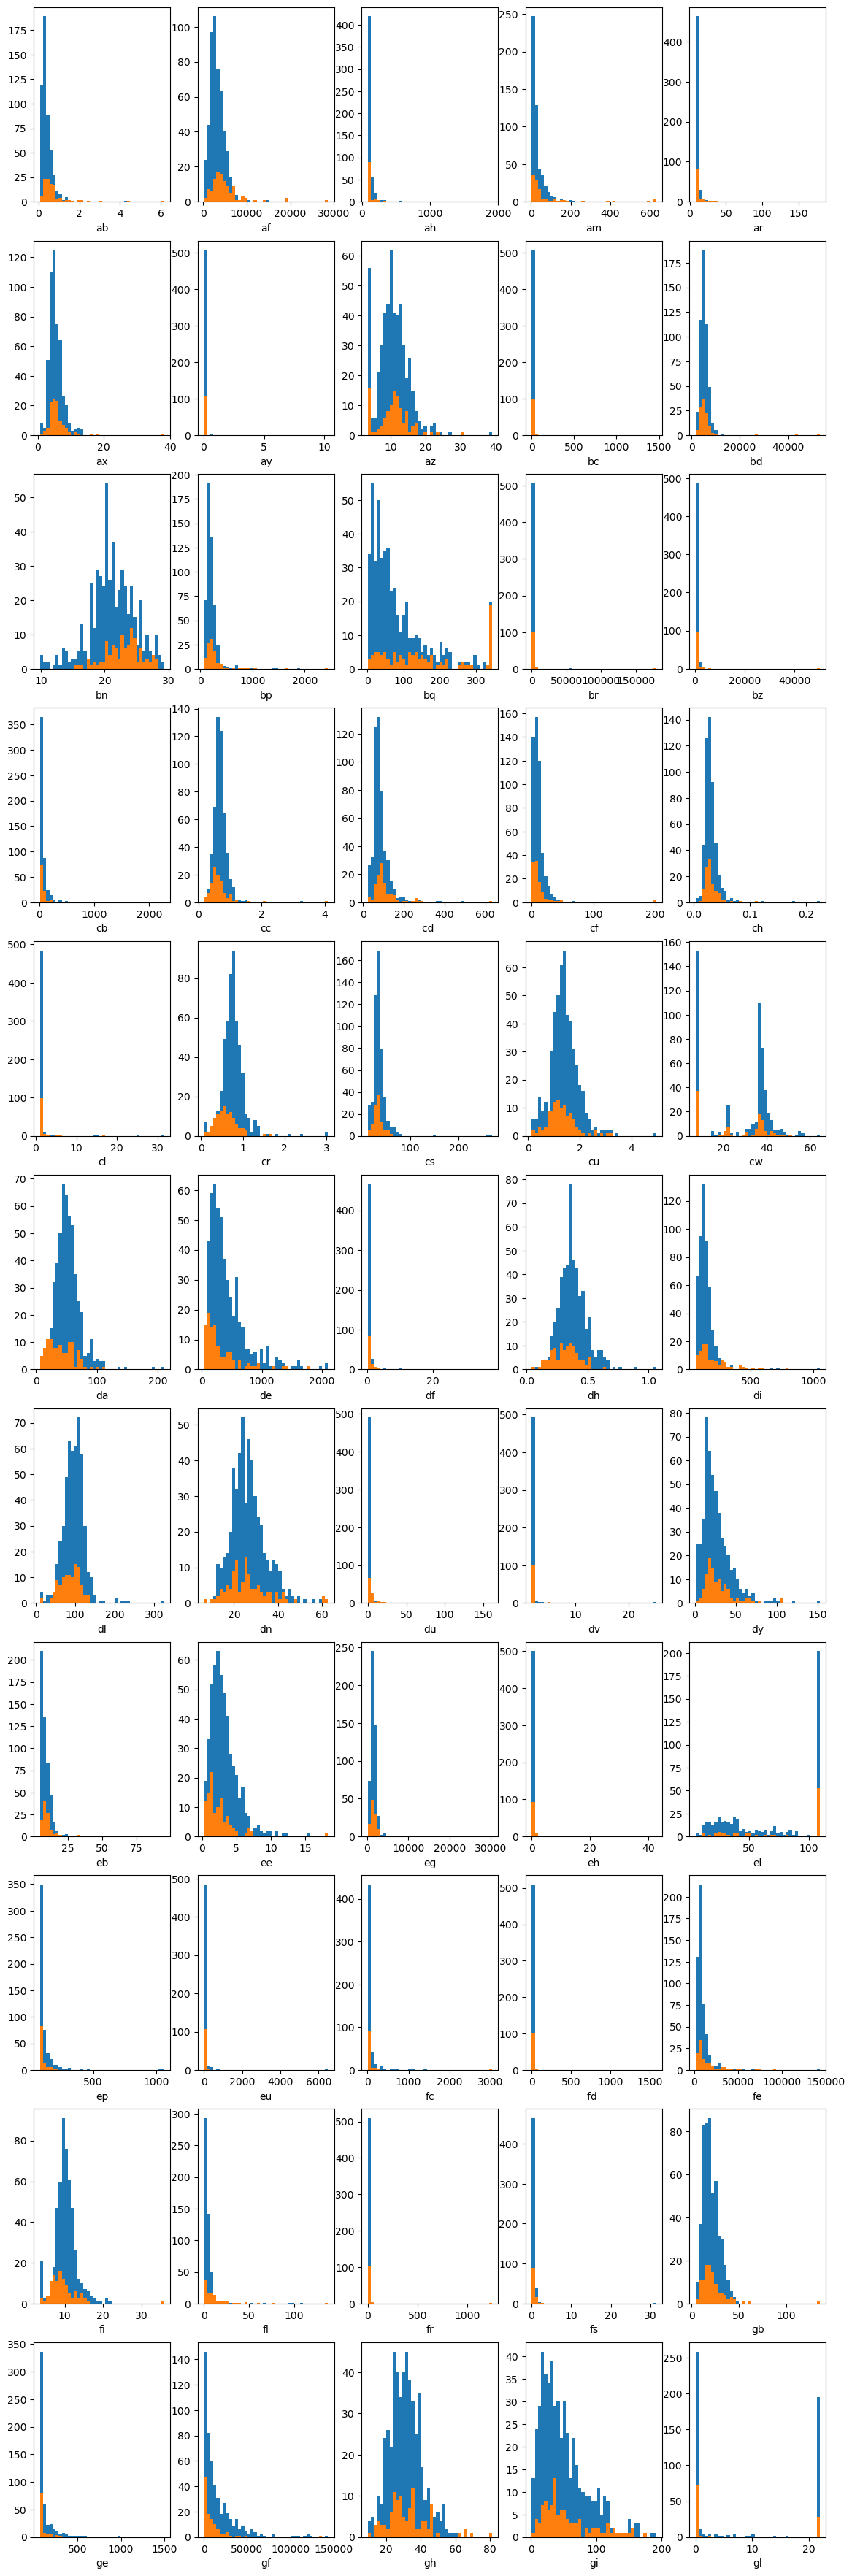

In [56]:
df_train = pd.DataFrame(features_variable).join(target_variable)
columns = list(df_train.columns)
fig, axes = plt.subplots(nrows=11, ncols=5, figsize=(14,45))
for idx, ax in enumerate(axes.flatten()):
    no_disease = df_train[df_train['class']==0][columns[idx]]
    disease = df_train[df_train['class']!=0][columns[idx]]
    bins=np.histogram(np.hstack((no_disease,disease)), bins=40)[1]
    ax.hist(no_disease, bins)
    ax.hist(disease, bins)
    ax.set_xlabel(columns[idx])

### Distributions after feature reduction (Graphs hardcoded for 24 features)

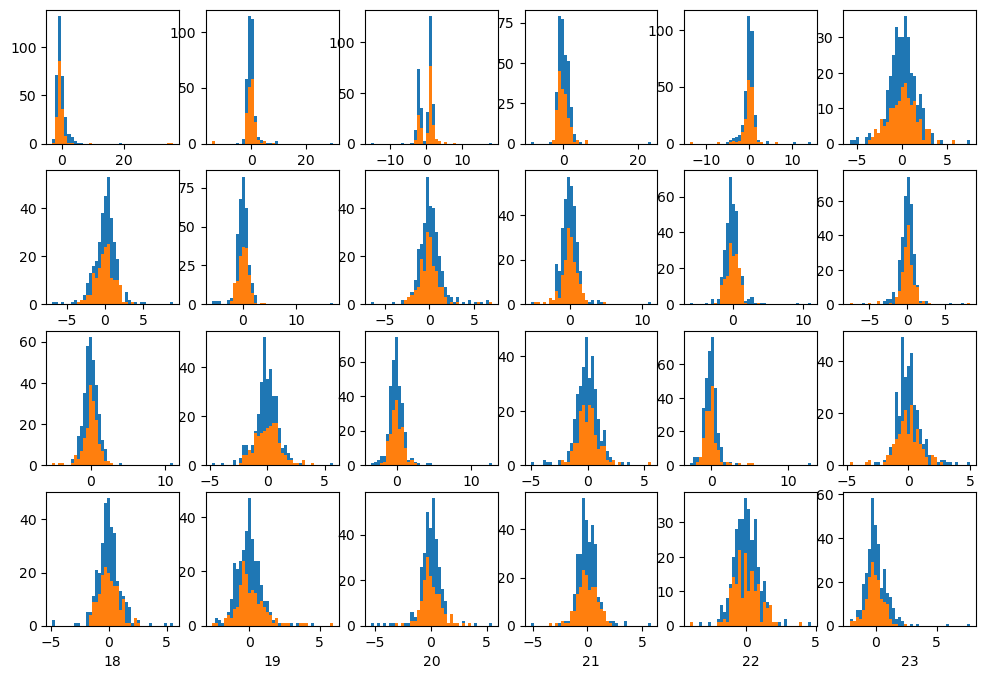

In [55]:
df_train_reduced = pd.DataFrame(X_train).join(Y_train)
columns = list(X_train.columns)
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(12,8))
for idx, ax in enumerate(axes.flatten()):
    no_disease = df_train_reduced[df_train_reduced['class']==0][columns[idx]]
    disease = df_train_reduced[df_train_reduced['class']!=0][columns[idx]]
    bins=np.histogram(np.hstack((no_disease,disease)), bins=40)[1]
    ax.hist(no_disease, bins)
    ax.hist(disease, bins)
    ax.set_xlabel(columns[idx])

### Visualizing clusting with tSNE feature reduction

In [9]:
tsne2 = TSNE(n_components=5, random_state=0, perplexity=40, n_iter=5000, method = 'exact')
t = tsne2.fit_transform(features_variable)

In [49]:
tsne2.kl_divergence_

0.31401928411518903

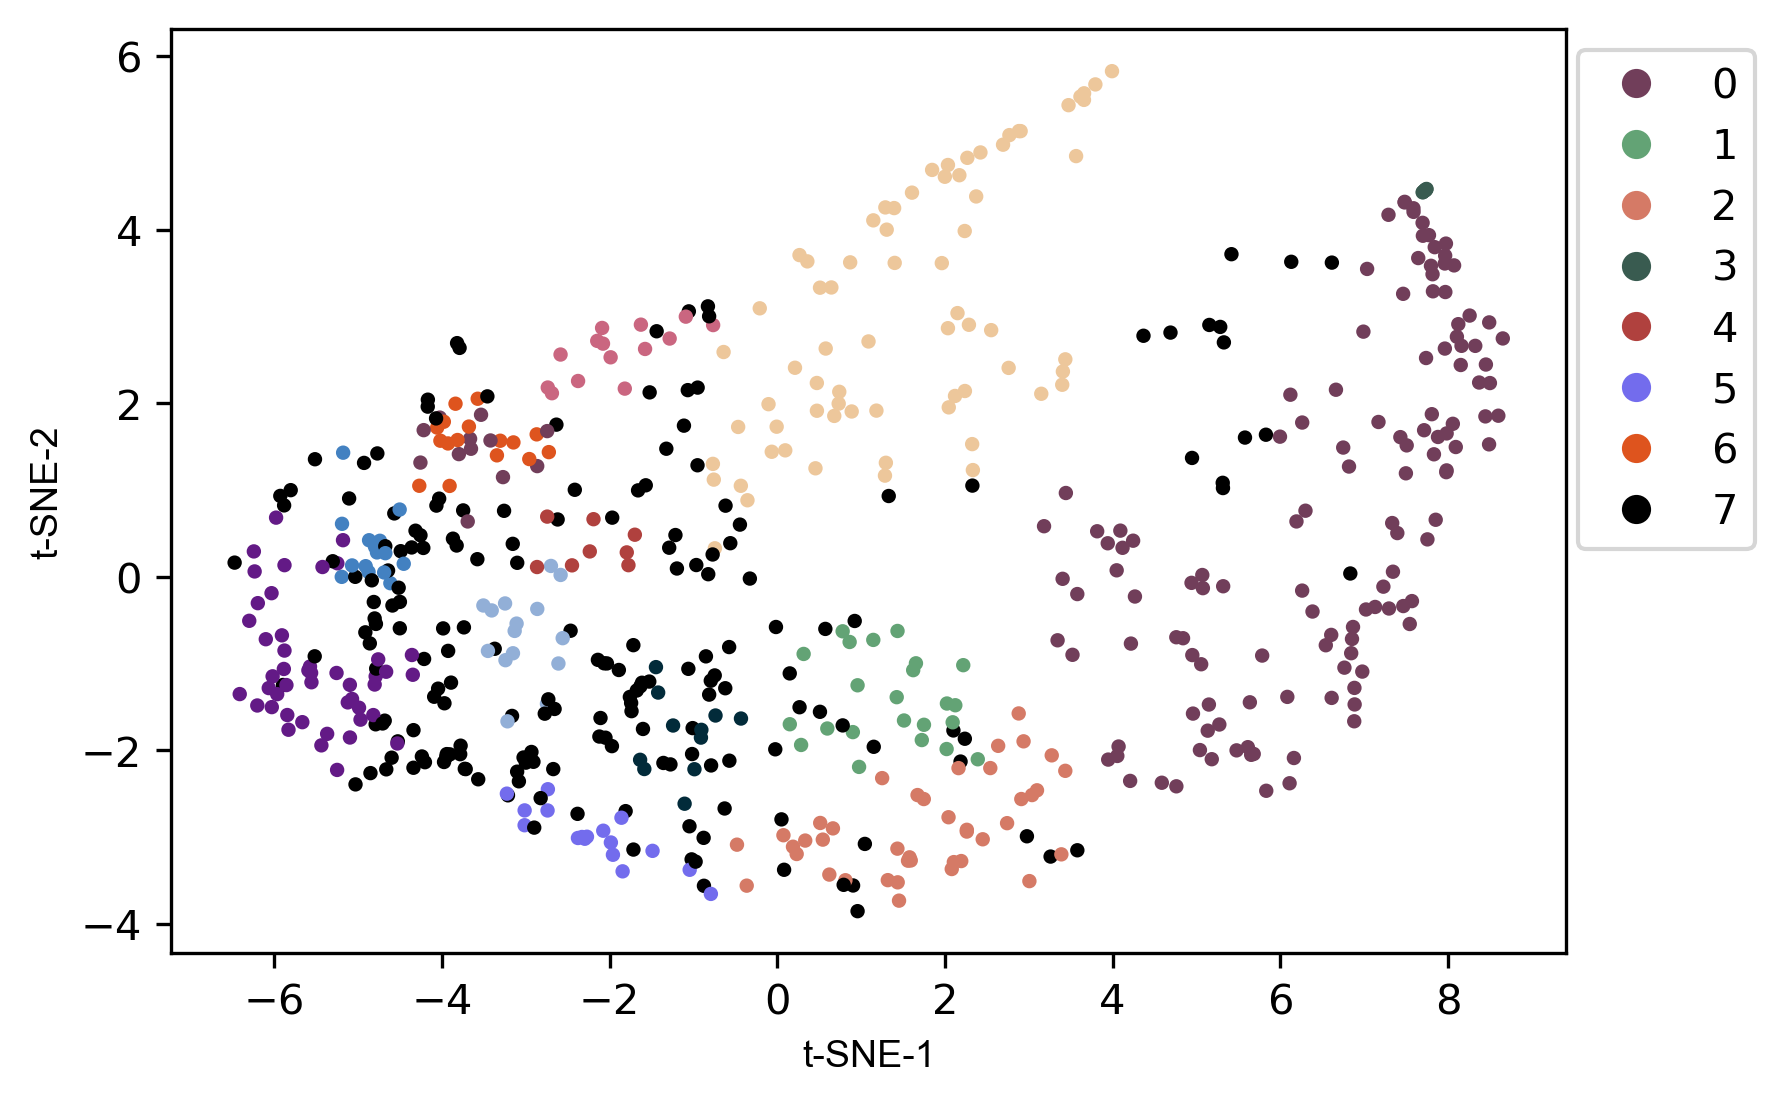

In [50]:
from bioinfokit.visuz import cluster
from sklearn.cluster import DBSCAN

get_clusters = DBSCAN(eps = 1, min_samples = 9).fit_predict(t)
cluster.tsneplot(score=t, colorlist=get_clusters, 
    colordot=('#713e5a', '#63a375', '#edc79b', '#d57a66', '#ca6680', '#395B50', '#92AFD7', '#b0413e', '#4381c1', '#736ced', '#631a86', '#de541e', '#022b3a', '#000000'), 
    legendpos='upper right', legendanchor=(1.15, 1))
Image(filename='tsne_2d.png', width=600)

### Graph displaying that 80% of feature variance is retained via PCA at just 23 features

Number of principal components explaining 80% of variance: 23


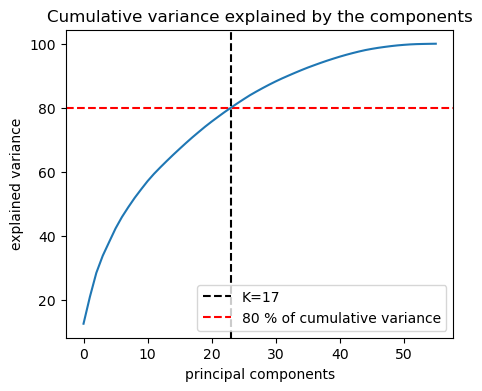

In [53]:
X_train, X_test, y_train, y_test, statistic = feature_reduction(method='pca', num_features=56, data_split=0.2)

# how many principal components explain 95% of the variance?
k = np.argmax(statistic>80)
print("Number of principal components explaining 80% of variance: "+ str(k))

plt.figure(figsize=[5,4])
plt.title('Cumulative variance explained by the components')
plt.ylabel('explained variance')
plt.xlabel('principal components')
plt.axvline(x=k, color="k", linestyle="--", label = "K=17")
plt.axhline(y=80, color="r", linestyle="--", label="80 % of cumulative variance")
ax = plt.plot(statistic)
              
plt.legend()

In [41]:
############################
### Final test and train ###
### for CSV output       ###
############################

X_train, X_test, Y_train, Y_test, statistic = feature_reduction(method='pca', num_features=24, data_split=0.2)

pd.DataFrame(X_train).to_csv('./data/X_train.csv')
pd.DataFrame(X_test).to_csv('./data/X_test.csv')
pd.DataFrame(Y_train).to_csv('./data/Y_train.csv')
pd.DataFrame(Y_test).to_csv('./data/Y_test.csv')


0